In [15]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [112]:
trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ft-data'
problemSize = 'medprob'
pava = 'VA'
trialsToUse=[0,1,2]

In [113]:
%%time
# let's open all the CSV files in the given directory
csvs = []
for trial in trialsToUse:
    csvs = csvs + list(glob.glob(trialsDir+'/'+'*-'+problemSize+'*-trial'+str(trial)+'*-'+pava+'-traces/*.csv'))

df = pd.DataFrame()
for csv in csvs:
    rawdf = pd.read_csv(csv, sep=' ')
    df = df.append(rawdf)
    
# let's only keep a few columns
df = df[['region', 'globalidx', 'policy', 'xtime']]
df = df.reset_index(drop=True)

CPU times: user 344 ms, sys: 15.1 ms, total: 359 ms
Wall time: 646 ms


In [114]:
%%time
# average out the xtimes for each trial
df = df.groupby(['region', 'globalidx', 'policy'])['xtime'].mean().reset_index().sort_values(by=['globalidx'])

CPU times: user 11 ms, sys: 43 µs, total: 11.1 ms
Wall time: 9.49 ms


In [115]:
%%time
# sanity check the shape
print(df.shape)
print(df.columns)

(333, 4)
Index(['region', 'globalidx', 'policy', 'xtime'], dtype='object')
CPU times: user 918 µs, sys: 0 ns, total: 918 µs
Wall time: 641 µs


In [119]:
def plotAllPolicies(df, policiesToPlot=[0,1,2]):
    df = df.loc[[ (x in policiesToPlot) for x in df['policy']]]
    
    grouped = df.groupby(['region', 'globalidx'])
    maxs = df.loc[grouped['xtime'].idxmax()]
    maxs = maxs.sort_values(by=['globalidx']).reset_index(drop=True)
    toplot = maxs.copy()

    # We will also count the number of unique regions, discrtize, and map them to integers
    regions = list(toplot['region'].unique())
    num_regions = len(regions)

    region_map = dict(zip(regions, range(num_regions)))

    # set the starting point of all the groups of policies
    toplot['x_start'] = toplot['xtime'].cumsum().shift(fill_value=0)

    toplot.drop('policy', axis=1, inplace=True)
    toplot.drop('xtime', axis=1, inplace=True)
    
    #now let's add the endpoint columns
    for pol in policiesToPlot:
        toplot['x_end'+str(pol)] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == pol].sort_values(by=['globalidx'])['xtime'].to_numpy()
    
    #toplot['x_end0'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 0].sort_values(by=['globalidx'])['xtime'].to_numpy()
    #toplot['x_end1'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 1].sort_values(by=['globalidx'])['xtime'].to_numpy()
    #toplot['x_end2'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 2].sort_values(by=['globalidx'])['xtime'].to_numpy()
    
    # make the y-axis values for each datapoint
    toplot['y'] = toplot.apply(lambda row: region_map[row.region], axis=1)
    
    # Now that we have the necessary columns, let's plot ALL the policies
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(18, 10)
    fig1.set_dpi(500)

    offset=0.1
    
    polData = [
               ('x_end0', offset, 'red', 'policy0'),
               ('x_end1', 0, 'green', 'policy1'),
               ('x_end2', -offset, 'blue', 'policy2')
              ]

    for index, row in toplot.iterrows():
        for pol in policiesToPlot:
            ax1.plot([row.x_start, row[polData[pol][0]]], [row.y+polData[pol][1], row.y+polData[pol][1]], color=polData[pol][2],   label=polData[pol][3], marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end0], [row.y+offset, row.y+offset], color='red',   label='policy0', marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end1], [row.y,        row.y       ], color='green', label='policy1', marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end2], [row.y-offset, row.y-offset], color='blue',  label='policy2', marker='o', markersize=4)
        if (index % 1000) == 0:
            print('current index: ', index, '(', 100*(index+1)/toplot.shape[0] ,')')

    print(region_map.keys())

    ax1.set_title(trialsDir+' -- averaged over '+pava+' trials:'+str(trialsToUse))
    #ax1.set_yticklabels(regions)
    ax1.set_yticks(list(region_map.values()))
    ax1.set_yticklabels(list(region_map.keys()))
    ax1.set_xlabel('Execution Time (seconds)')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    
def plotOptimalPolicy(df, policiesToPlot=[0,1,2]):
    df = df.loc[[ (x in policiesToPlot) for x in df['policy']]]
    
    grouped = df.groupby(['region', 'globalidx'])
    mins = df.loc[grouped['xtime'].idxmin()]
    mins = mins.sort_values(by=['globalidx']).reset_index(drop=True)
    toplot = mins.copy()
    
    # We will also count the number of unique regions, discrtize, and map them to integers
    regions = list(toplot['region'].unique())
    num_regions = len(regions)

    region_map = dict(zip(regions, range(num_regions)))

    # set the starting point of all the groups of policies
    toplot['x_end'] = toplot['xtime'].cumsum()
    toplot['x_start'] = toplot['x_end'].shift(fill_value=0)

    #toplot.drop('policy', axis=1, inplace=True)
    toplot.drop('xtime', axis=1, inplace=True)
    
    # make the y-axis values for each datapoint
    toplot['y'] = toplot.apply(lambda row: region_map[row.region], axis=1)
    
    policyColors = ['red', 'green', 'blue']
    
    # Now that we have the necessary columns, let's plot ALL the policies
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(18, 10)
    fig1.set_dpi(500)

    for index, row in toplot.iterrows():
        ax1.plot([row.x_start, row.x_end], [row.y, row.y], color=policyColors[row.policy],   label='policy'+str(row.policy), marker='o', markersize=4)
        if (index % 1000) == 0:
            print('current index: ', index, '(', 100*(index+1)/toplot.shape[0] ,')')

    print(region_map.keys())

    ax1.set_title(trialsDir+' -- averaged over '+pava+' trials:'+str(trialsToUse))
    #ax1.set_yticklabels(regions)
    ax1.set_yticks(list(region_map.values()))
    ax1.set_yticklabels(list(region_map.keys()))
    ax1.set_xlabel('Execution Time (seconds)')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    
    

    return
    

current index:  0 ( 0.9009009009009009 )
dict_keys(['ft.c.apollo.region.l199', 'ft.c.apollo.region.l376', 'ft.c.apollo.region.l263', 'ft.c.apollo.region.l447', 'ft.c.apollo.region.l480', 'ft.c.apollo.region.l513', 'ft.c.apollo.region.l223', 'ft.c.apollo.region.l676'])
CPU times: user 369 ms, sys: 1.13 ms, total: 370 ms
Wall time: 366 ms


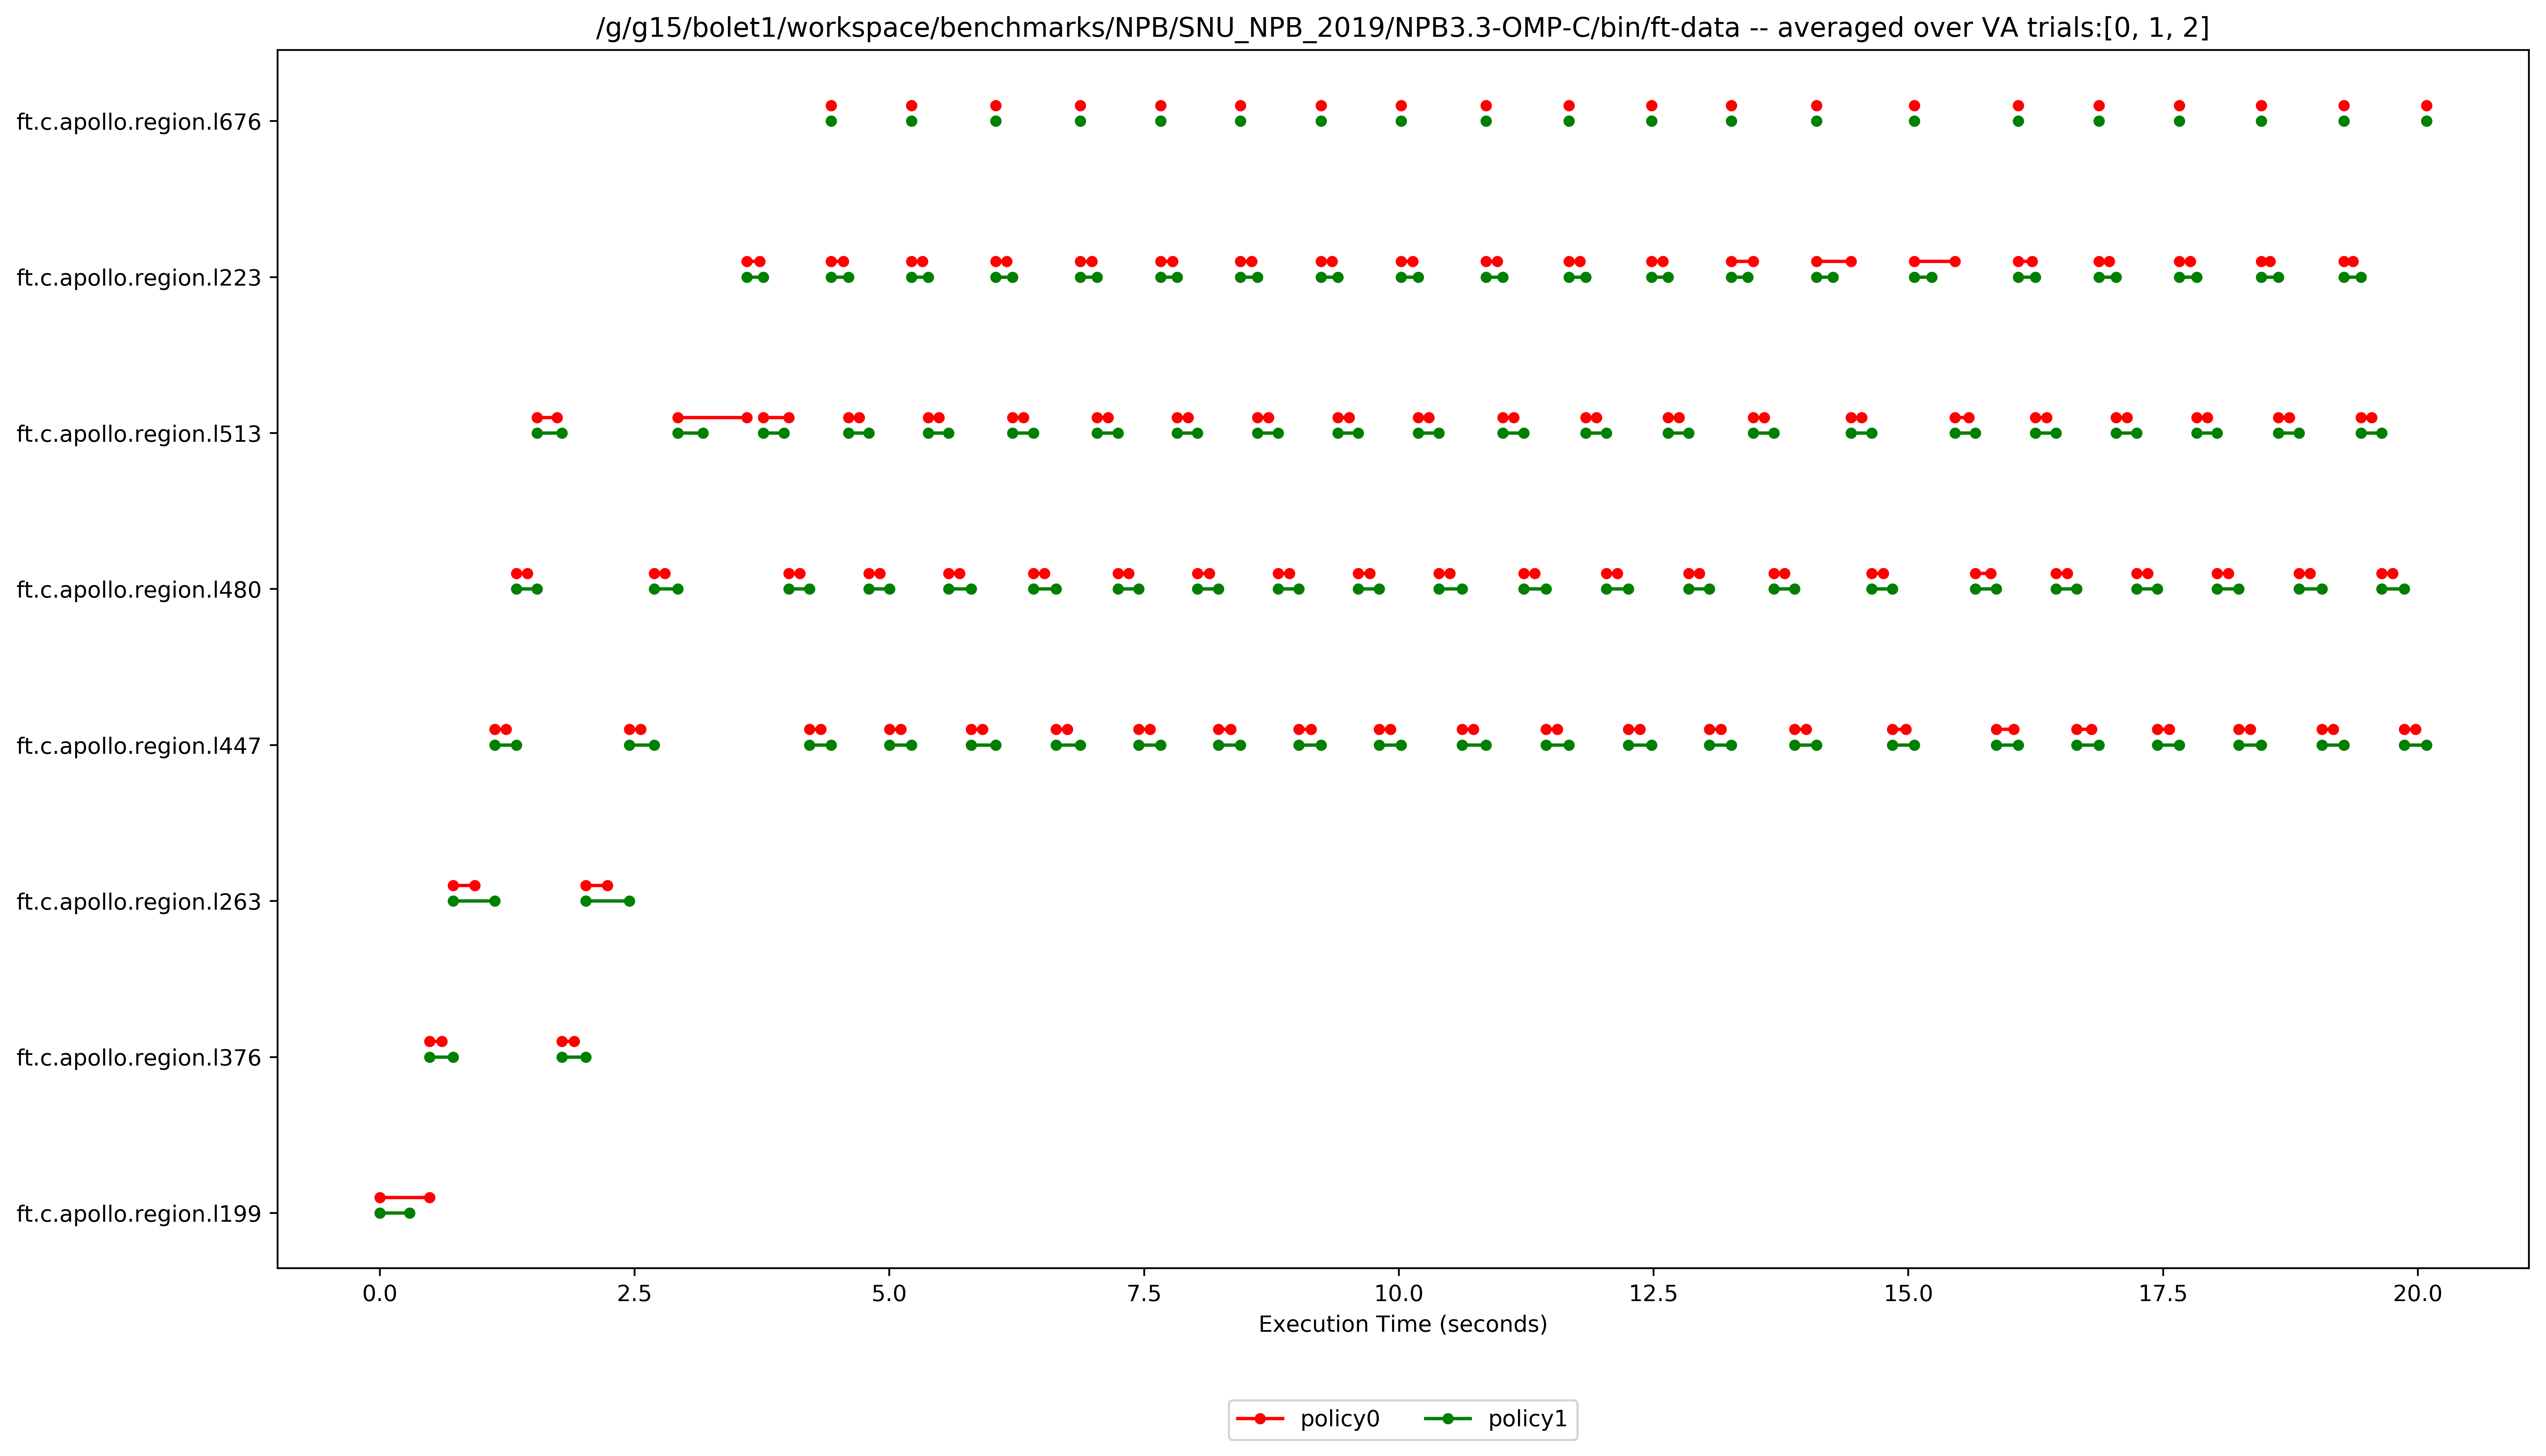

In [120]:
%%time
plotAllPolicies(df, policiesToPlot=[0,1])


current index:  0 ( 0.9009009009009009 )
dict_keys(['ft.c.apollo.region.l199', 'ft.c.apollo.region.l376', 'ft.c.apollo.region.l263', 'ft.c.apollo.region.l447', 'ft.c.apollo.region.l480', 'ft.c.apollo.region.l513', 'ft.c.apollo.region.l223', 'ft.c.apollo.region.l676'])
CPU times: user 216 ms, sys: 3 ms, total: 219 ms
Wall time: 216 ms


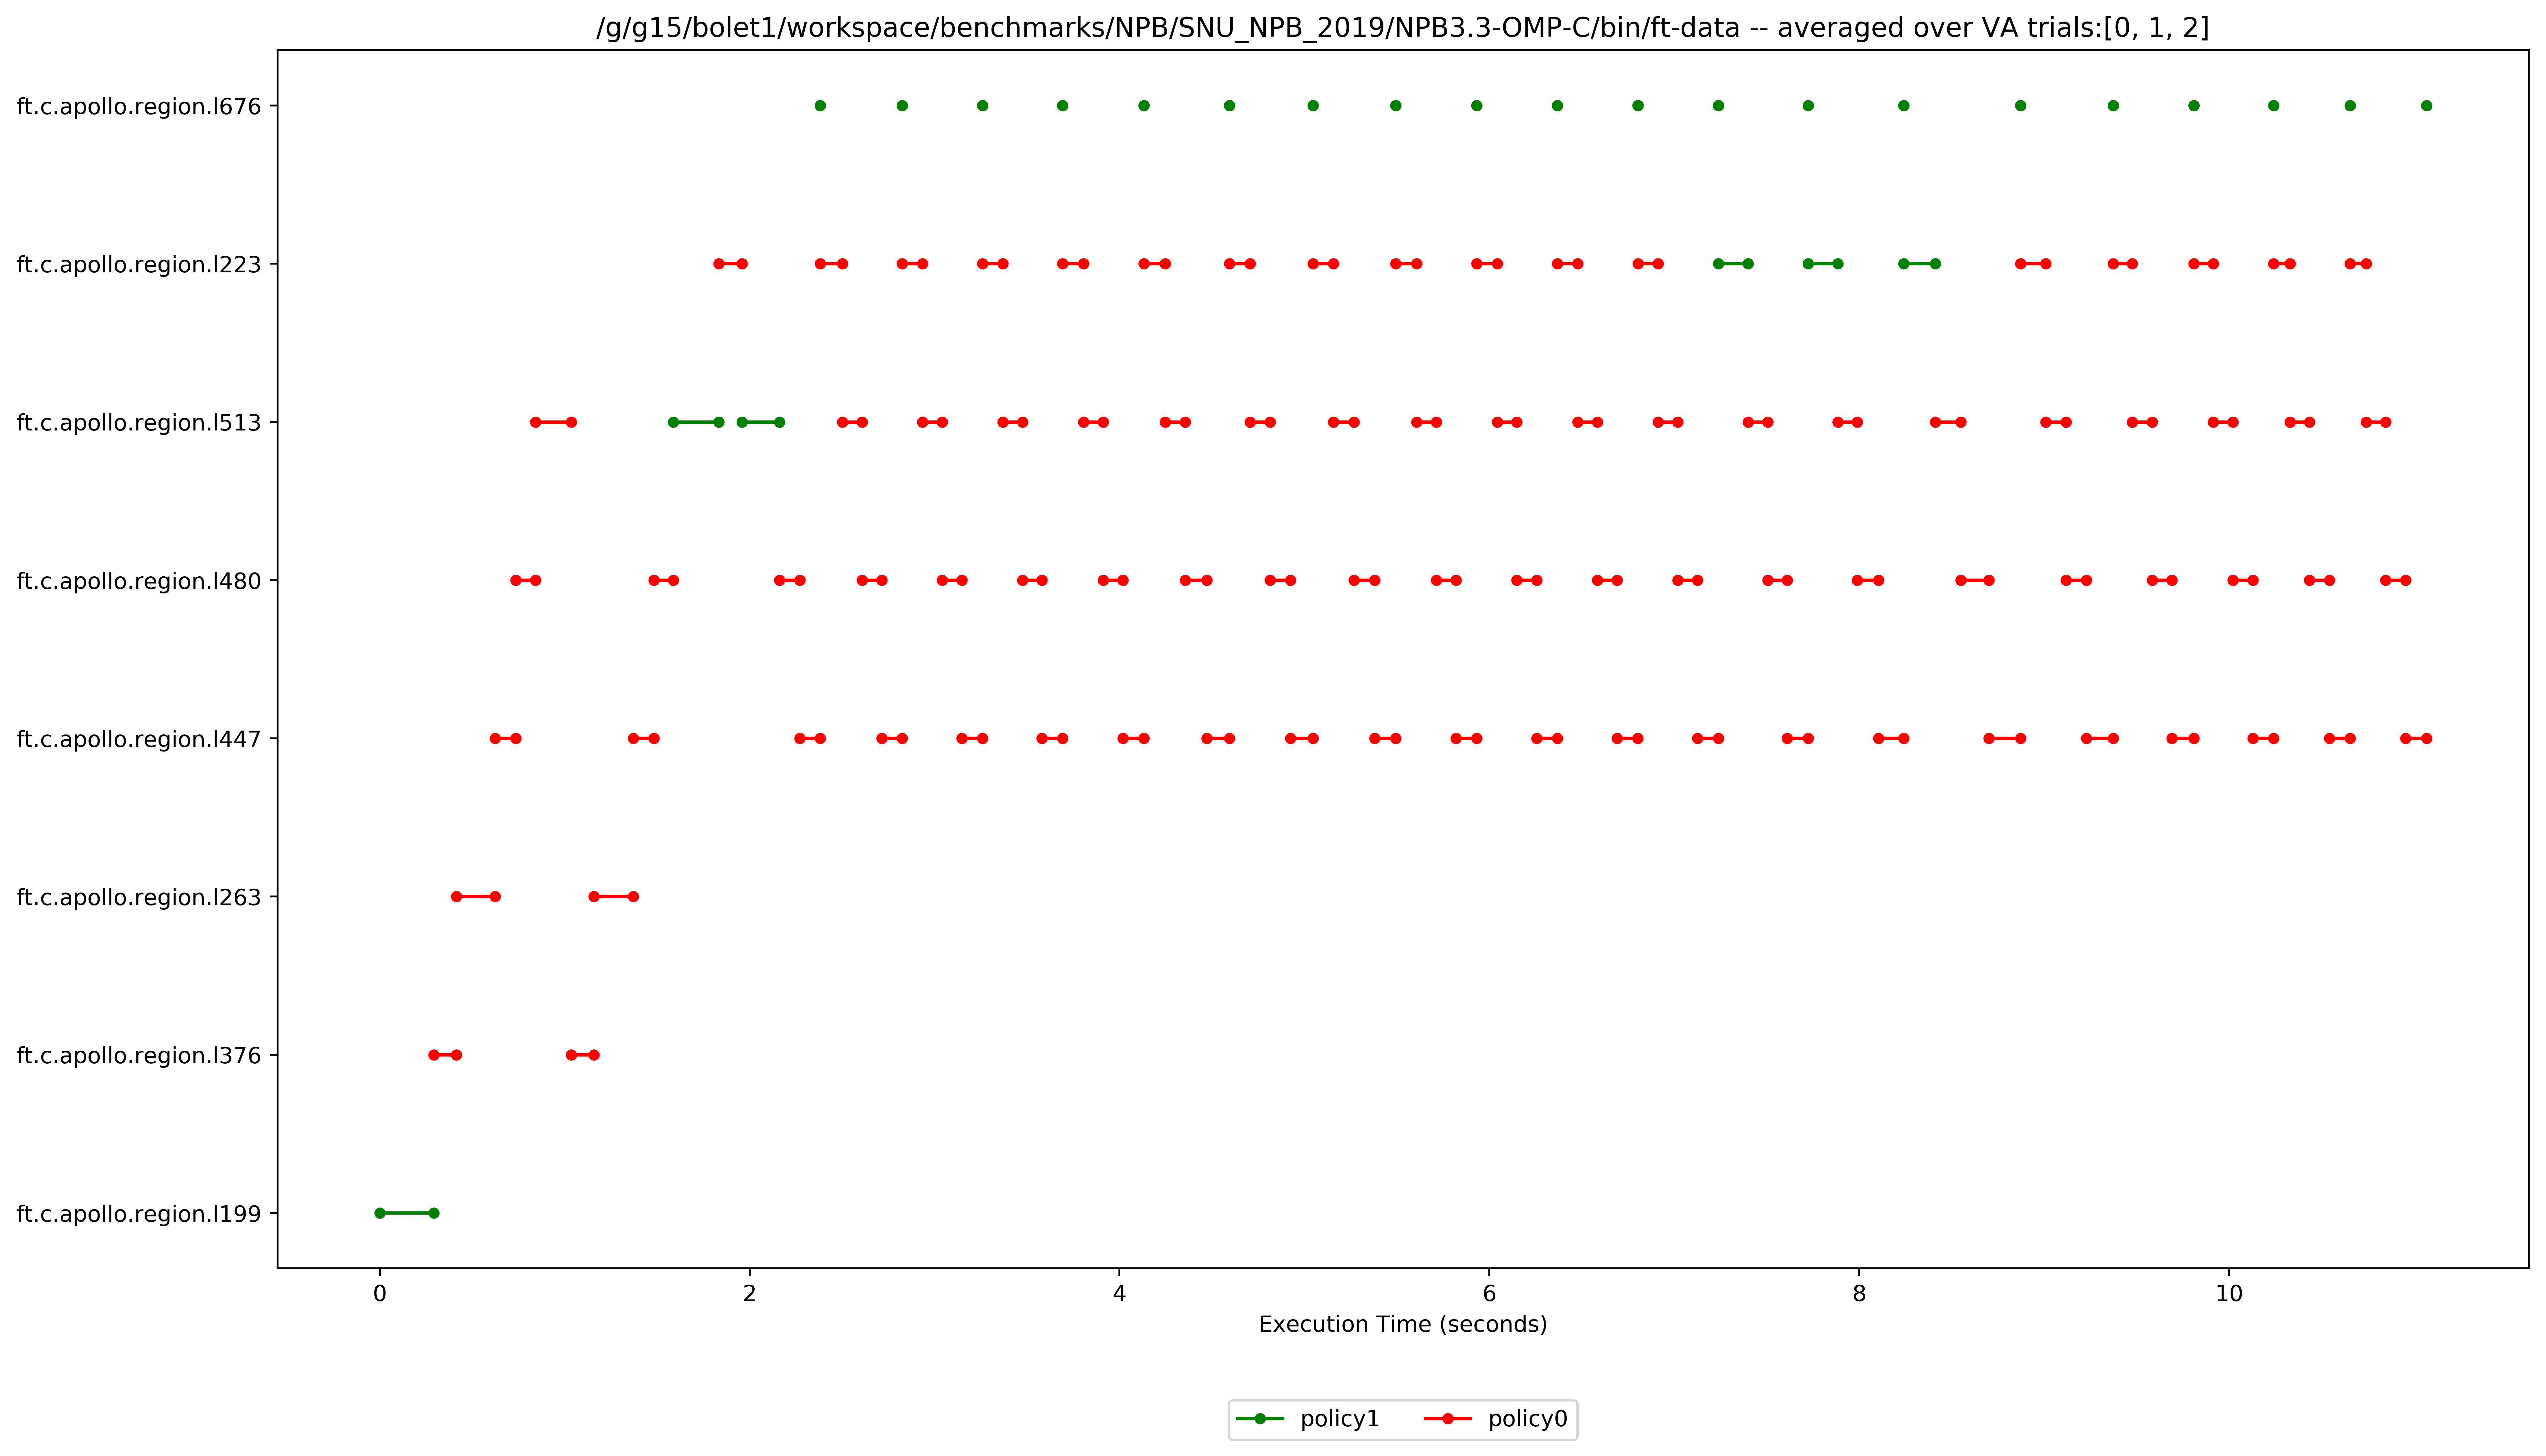

In [121]:
%%time
plotOptimalPolicy(df, policiesToPlot=[0,1,2])

In [84]:
# for now we will only support making a plot for one trial
# we assume the path has all static run data for the benchmark
target_path = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ft-data/ft-medprob-trial0-VA-traces'

#target_path = '/g/g15/bolet1/workspace/lulesh-region-fix-correct/LULESH/build/lulesh-data/lulesh-smallprob-trial0-VA-traces'





In [85]:
%%time
# let's open all the CSV files in the given directory
csvs = list(glob.glob(target_path+'/*.csv'))

df = pd.DataFrame()
for csv in csvs:
    rawdf = pd.read_csv(csv, sep=' ')
    df = df.append(rawdf)
    
# let's only keep a few columns
df = df[['region', 'globalidx', 'policy', 'xtime']]
df = df.reset_index(drop=True)

CPU times: user 102 ms, sys: 5.08 ms, total: 107 ms
Wall time: 233 ms


In [5]:
%%time
# let's find the optimal policy from the traces
# groupby region and globalidx
grouped = df.groupby(['region', 'globalidx'])

CPU times: user 291 µs, sys: 169 µs, total: 460 µs
Wall time: 468 µs


In [6]:
%%time

#mins = df.loc[grouped['xtime'].idxmin()]
# get only the max xtimes for each group
maxs = df.loc[grouped['xtime'].idxmax()]

CPU times: user 31.4 ms, sys: 1.2 ms, total: 32.6 ms
Wall time: 30.9 ms


In [7]:
%%time

#mins = mins.sort_values(by=['globalidx']).reset_index(drop=True)
#print(mins)

# sort the xtimes by order of execution
maxs = maxs.sort_values(by=['globalidx']).reset_index(drop=True)
print(maxs)

#print('testing')
#print(mins.groupby((mins["region"] != mins["region"].shift()).cumsum()).agg({"xtime" : ["min", "max"]}))

# let's create the plot for this optimal policy

                      region  globalidx  policy     xtime
0    ft.c.apollo.region.l199          0       2  0.796085
1    ft.c.apollo.region.l376          1       2  0.973295
2    ft.c.apollo.region.l263          2       2  1.853430
3    ft.c.apollo.region.l447          3       2  0.972609
4    ft.c.apollo.region.l480          4       2  0.636560
5    ft.c.apollo.region.l513          5       2  0.932010
6    ft.c.apollo.region.l376          6       2  0.868710
7    ft.c.apollo.region.l263          7       2  1.442190
8    ft.c.apollo.region.l447          8       2  0.735668
9    ft.c.apollo.region.l480          9       2  0.513614
10   ft.c.apollo.region.l513         10       2  0.710312
11   ft.c.apollo.region.l223         11       2  0.188350
12   ft.c.apollo.region.l513         12       2  0.536335
13   ft.c.apollo.region.l480         13       2  0.570979
14   ft.c.apollo.region.l447         14       2  0.745898
15   ft.c.apollo.region.l676         15       2  0.000120
16   ft.c.apol

In [8]:
%%time

# Now let's make a new dataframe that holds all the desired information we want to plot
toplot = maxs.copy()

# We will also count the number of unique regions, discrtize, and map them to integers
regions = list(toplot['region'].unique())
num_regions = len(regions)
print(num_regions, 'regions:', regions)
region_map = dict(zip(regions, range(num_regions)))
print(region_map)

# set the starting point of all the groups of policies
toplot['x_start'] = toplot['xtime'].cumsum().shift(fill_value=0)

toplot.drop('policy', axis=1, inplace=True)
toplot.drop('xtime', axis=1, inplace=True)

print(toplot)


8 regions: ['ft.c.apollo.region.l199', 'ft.c.apollo.region.l376', 'ft.c.apollo.region.l263', 'ft.c.apollo.region.l447', 'ft.c.apollo.region.l480', 'ft.c.apollo.region.l513', 'ft.c.apollo.region.l223', 'ft.c.apollo.region.l676']
{'ft.c.apollo.region.l199': 0, 'ft.c.apollo.region.l376': 1, 'ft.c.apollo.region.l263': 2, 'ft.c.apollo.region.l447': 3, 'ft.c.apollo.region.l480': 4, 'ft.c.apollo.region.l513': 5, 'ft.c.apollo.region.l223': 6, 'ft.c.apollo.region.l676': 7}
                      region  globalidx    x_start
0    ft.c.apollo.region.l199          0   0.000000
1    ft.c.apollo.region.l376          1   0.796085
2    ft.c.apollo.region.l263          2   1.769380
3    ft.c.apollo.region.l447          3   3.622810
4    ft.c.apollo.region.l480          4   4.595419
5    ft.c.apollo.region.l513          5   5.231979
6    ft.c.apollo.region.l376          6   6.163989
7    ft.c.apollo.region.l263          7   7.032699
8    ft.c.apollo.region.l447          8   8.474889
9    ft.c.apollo.regi

In [9]:
%%time

print(df.dtypes)
print(df['policy'].unique())
print(toplot['x_start'].dtype)
print(df.loc[df['policy'] == 0].sort_values(by=['globalidx'])['xtime'].shape)
print(df.loc[df['policy'] == 1].sort_values(by=['globalidx'])['xtime'].shape)
#print(df.loc[df['policy'] == 2].sort_values(by=['globalidx'])['xtime'].dtype)

#now let's add the endpoint columns
toplot['x_end0'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 0].sort_values(by=['globalidx'])['xtime'].to_numpy()
toplot['x_end1'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 1].sort_values(by=['globalidx'])['xtime'].to_numpy()
#toplot['x_end2'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 2].sort_values(by=['globalidx'])['xtime'].to_numpy()

region        object
globalidx      int64
policy         int64
xtime        float64
dtype: object
[0 1 2]
float64
(111,)
(111,)
CPU times: user 10.5 ms, sys: 2.13 ms, total: 12.6 ms
Wall time: 11.2 ms


In [10]:
%%time

# now let's add the y-values
# make the y-axis values for each datapoint
toplot['y'] = toplot.apply(lambda row: region_map[row.region], axis=1)

CPU times: user 6.86 ms, sys: 0 ns, total: 6.86 ms
Wall time: 8.1 ms


In [11]:
#print(toplot.head(), '\n\n', toplot.tail(), '\n\n', toplot.dtypes)


current index:  0 ( 0.9009009009009009 )
dict_keys(['ft.c.apollo.region.l199', 'ft.c.apollo.region.l376', 'ft.c.apollo.region.l263', 'ft.c.apollo.region.l447', 'ft.c.apollo.region.l480', 'ft.c.apollo.region.l513', 'ft.c.apollo.region.l223', 'ft.c.apollo.region.l676'])
CPU times: user 405 ms, sys: 21.8 ms, total: 427 ms
Wall time: 422 ms


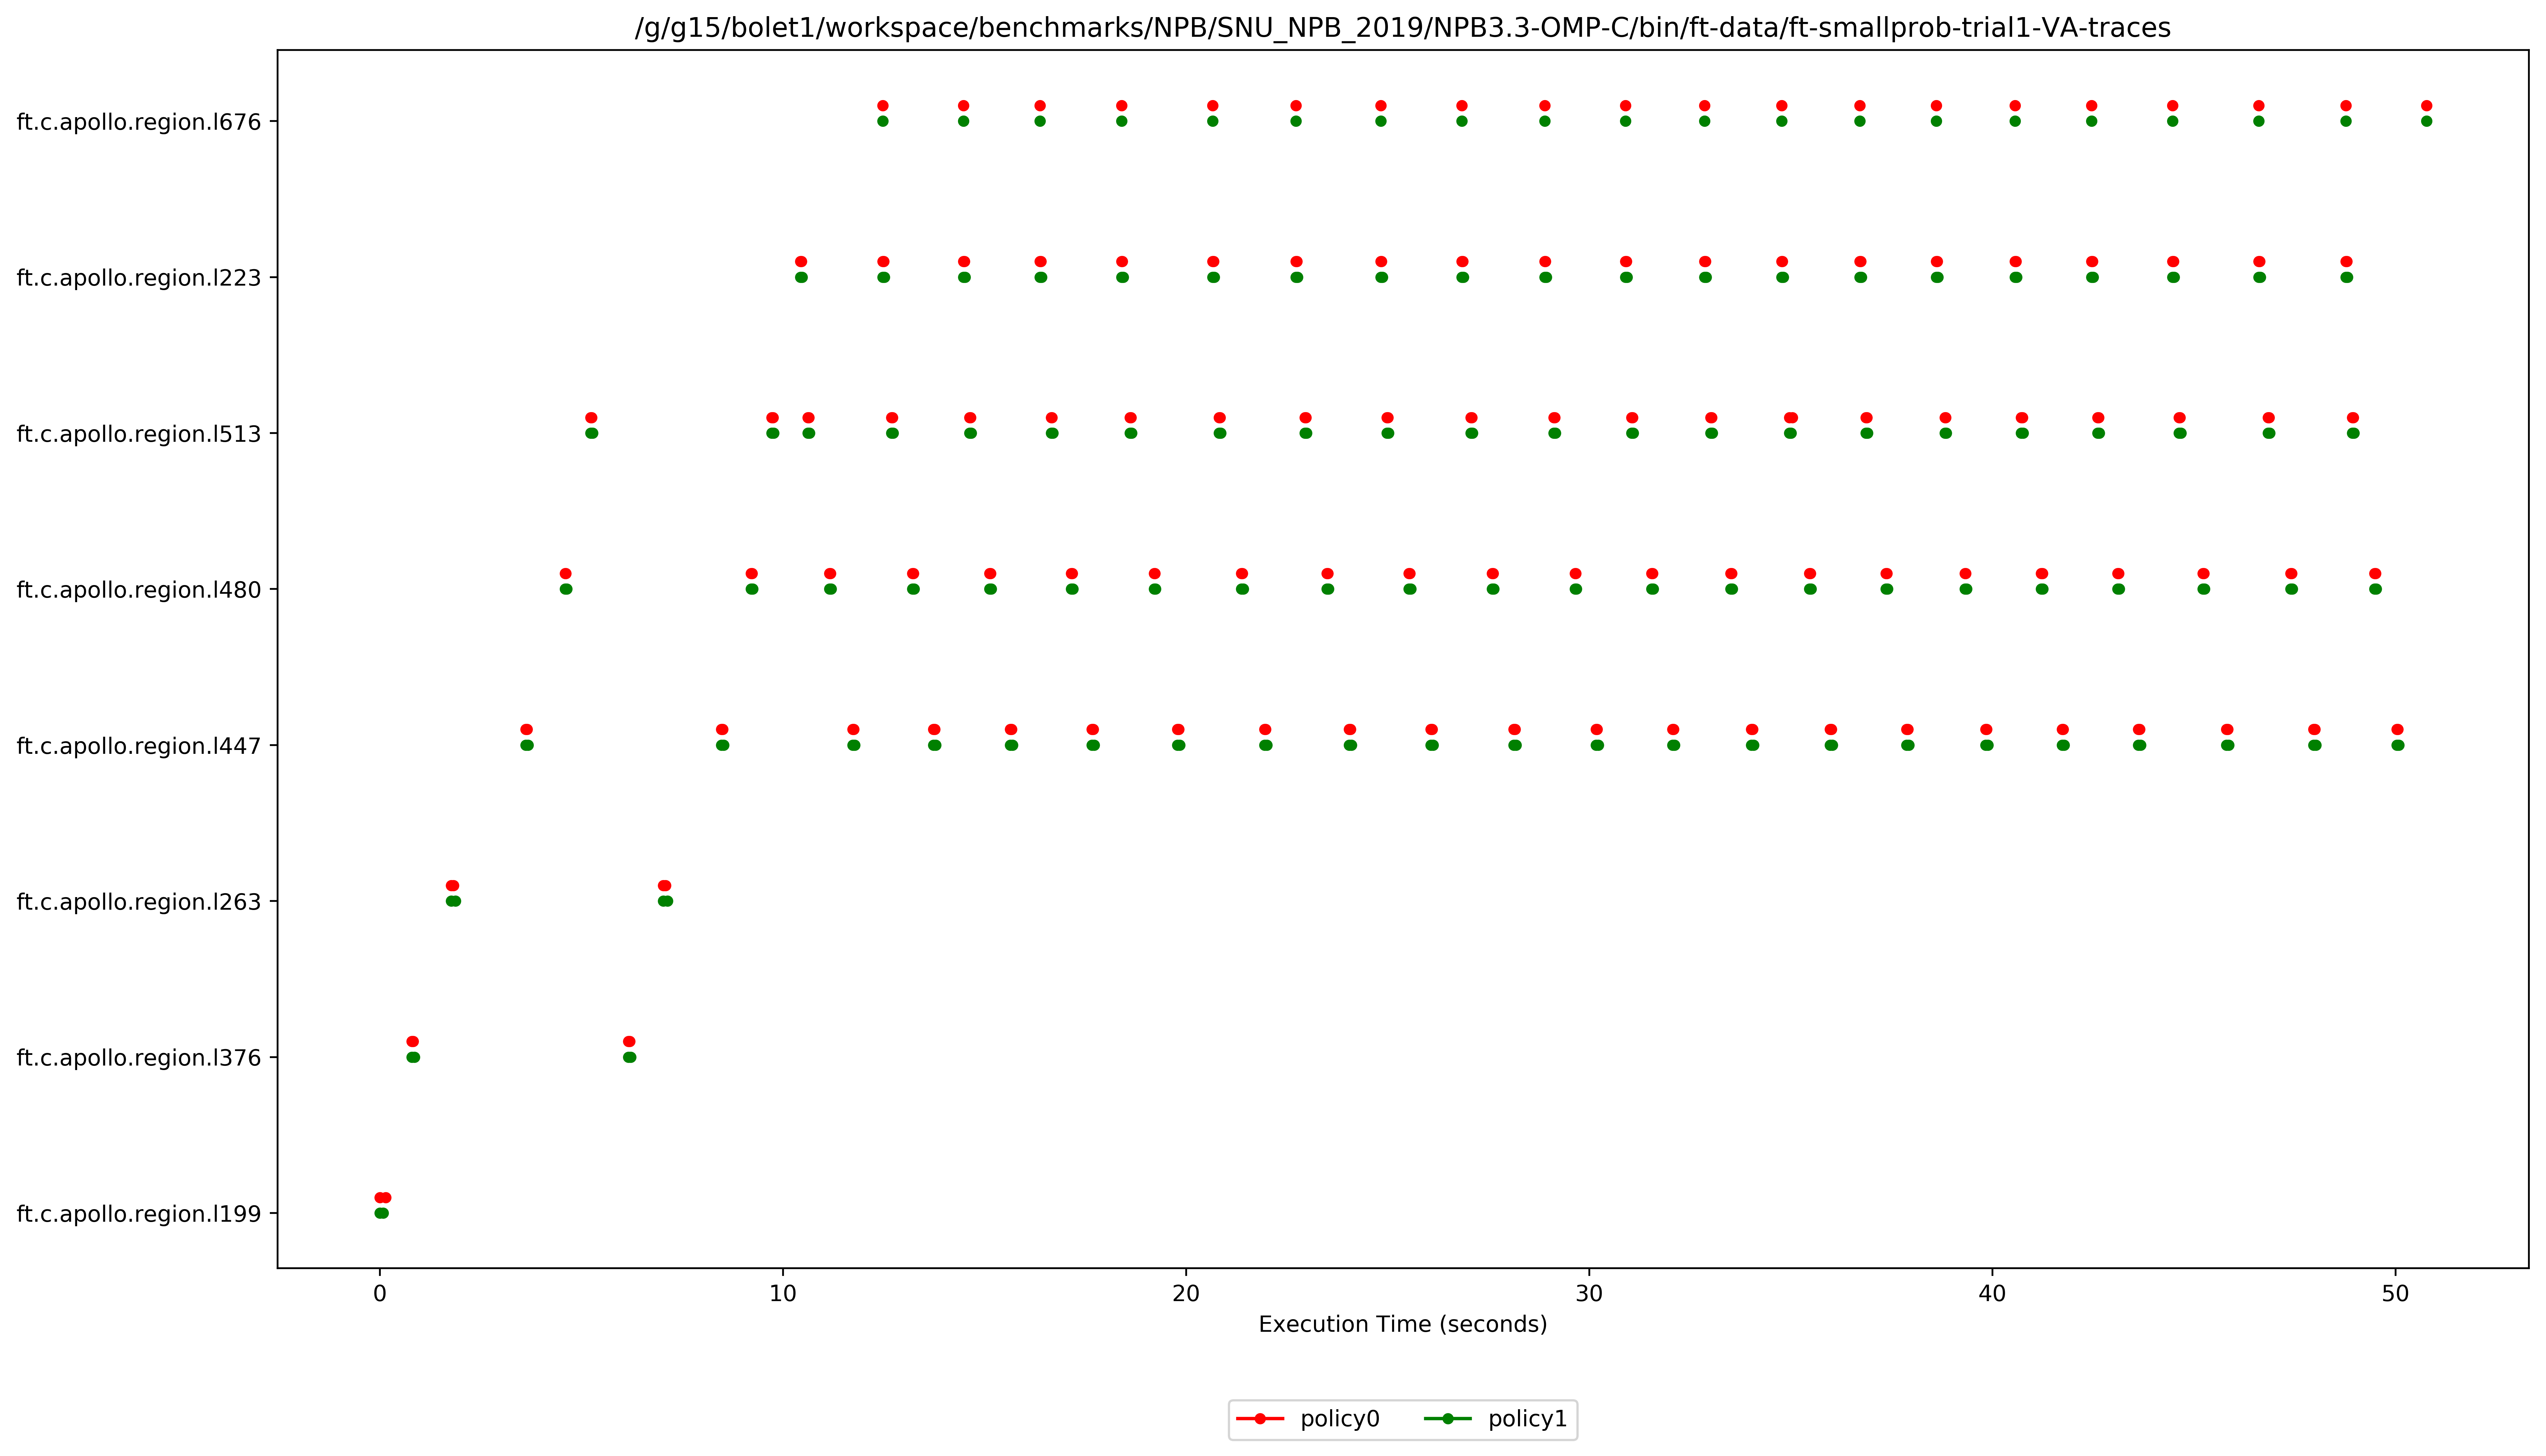

In [12]:
%%time

# Now that we have the necessary columns, let's plot ALL the policies
fig1, ax1 = plt.subplots()
fig1.set_size_inches(18, 10)
fig1.set_dpi(500)

offset=0.1

for index, row in toplot.iterrows():
    ax1.plot([row.x_start, row.x_end0], [row.y+offset, row.y+offset], color='red',   label='policy0', marker='o', markersize=4)
    ax1.plot([row.x_start, row.x_end1], [row.y,        row.y       ], color='green', label='policy1', marker='o', markersize=4)
    #ax1.plot([row.x_start, row.x_end2], [row.y-offset, row.y-offset], color='blue',  label='policy2', marker='o', markersize=4)
    if (index % 1000) == 0:
        print('current index: ', index, '(', 100*(index+1)/toplot.shape[0] ,')')
    
print(region_map.keys())

ax1.set_title(target_path)
#ax1.set_yticklabels(regions)
ax1.set_yticks(list(region_map.values()))
ax1.set_yticklabels(list(region_map.keys()))
ax1.set_xlabel('Execution Time (seconds)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
